# **Sentiment Analysis of Google Play Store Reviews Using BiLSTM and fastText Word Embedding**
Model *deep learning* yang dibangun menggunakan *PyTorch* dan *TorchText* untuk mengklasifikasikan sentimen ulasan aplikasi menggunakan data yang diambil dari *Google Play Store*.

(Kode ini untuk skripsi)

1. [Pengumpulan Data](#1-pengumpulan-data)
2. [Preprocessing Data](#2-preprocessing-data)
    - Text Cleaning
    - Case Folding
    - Tokenization
    - Stopword Removal
    - Stemming
3. [Pelabelan Data](#3-pelabelan-data)
4. [Pembagian Data](#4-pembagian-data-wip)
5. [Ekstraksi Fitur fastText](#5-ekstraksi-fitur-fasttext)
6. [Pembentukan Model BiLSTM](#6-pembentukan-model-bilstm)
7. [Pelatihan Model](#7-pelatihan-model)
8. [Klasifikasi Sentimen](#8-klasifikasi-sentimen)
9. [Evaluasi Model](#9-evaluasi-model)

<a id='section1'></a>
# **1. Pengumpulan Data**
Pada tahap pengumpulan data, penelitian ini melakukan scraping data ulasan pada Google Play Store terhadap aplikasi Maxim dengan menggunakan package google-play-scraper. Data yang diambil berjumlah 10.000 ulasan berbahasa Indonesia terbaru pada aplikasi Maxim.

Dalam ulasan aplikasi, sentimen positif sering kali lebih dominan daripada negatif. Jika kita mengambil data secara acak, kemungkinan besar kita mendapatkan bias ke kelas positif, yang dapat menyebabkan model menjadi terlalu condong ke sentimen positif. Mengambil jumlah yang sama untuk ulasan positif dan negatif (rating 1-2 untuk negatif, 4-5 untuk positif) membantu menghindari bias ini, sehingga model dapat belajar secara merata dari kedua sentimen.

(Penggunaan skema ini mungkin berpengaruh pada penentuan metode penarikan sampel)

In [40]:
# Package yang diperlukan untuk analisis sentimen
from google_play_scraper import app, Sort, reviews 
import os                               
import json                                         
import csv                                          
import pandas as pd                                 
import numpy as np
import re
import time
import spacy
import random
from pathlib import Path
from datetime import datetime
from collections import Counter
from pprint import pprint

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchtext.legacy
from torchtext.legacy import data 
from torchtext.vocab import Vectors

import fasttext
import fasttext.util
import gensim
import compress_fasttext

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import ast
from googletrans import Translator
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
# Mengubah working directory
os.chdir('D:\Dokumen\Skripsi\Referensi\Kode\Sentiment Analysis_BiLSTM_fastText')

In [ ]:
# Kode scraping data ulasan aplikasi Maxim
# Fungsi untuk memberikan label berdasarkan rating ulasan
def label_sentiment(rating):
    if rating in [1, 2]:
        return 'negatif'
    elif rating in [4, 5]:
        return 'positif'
    return None  # Untuk kasus ulasan dengan rating 3, tidak diberi label dan akan dihapus

# Variabel untuk menyimpan ulasan berlabel positif dan negatif
low_rating_reviews = []     # Ulasan dengan rating 1-2
high_rating_reviews = []    # Ulasan dengan rating 4-5

# Target jumlah ulasan untuk masing-masing kategori
target_count = 2500

# Proses scraping ulasan
while len(low_rating_reviews) < target_count or len(high_rating_reviews) < target_count:
    # Ambil batch ulasan dengan jumlah tinggi
    reviews_data, continuation_token = reviews(
        'com.taxsee.taxsee',    # id aplikasi dari URL aplikasi pada Google Play Store
        lang='id',              # Bahasa ulasan
        country='id',           # Negara ulasan
        sort=Sort.NEWEST,       # Sortir ulasan terbaru
        count=100000            # Ambil batch ulasan besar
    )

    # Proses setiap ulasan
    for review in reviews_data:
        # Hentikan jika kedua kategori ulasan sudah memenuhi target
        if len(low_rating_reviews) >= target_count and len(high_rating_reviews) >= target_count:
            break

        rating = review.get('score')
        sentiment = label_sentiment(rating)

        # Tambahkan ulasan berdasarkan sentimen
        if sentiment == 'negatif' and len(low_rating_reviews) < target_count:
            low_rating_reviews.append(review)
        elif sentiment == 'positif' and len(high_rating_reviews) < target_count:
            high_rating_reviews.append(review)

    # Hentikan jika semua target terpenuhi
    if len(low_rating_reviews) >= target_count and len(high_rating_reviews) >= target_count:
        break

    # Hentikan jika tidak ada token kelanjutan (ulasan habis)
    if continuation_token is None:
        break

# Gabungkan ulasan dengan rating rendah dan tinggi
combined_reviews = low_rating_reviews + high_rating_reviews

# Simpan hasil scraping ke dalam file CSV
with open('combined_reviews.csv', 'w', encoding='utf8', newline='') as output_file:
    # Hanya menyimpan kolom yang relevan
    fieldnames = ['content', 'score']  # Tidak ada kolom sentimen di tahap ini
    writer = csv.DictWriter(output_file, fieldnames=fieldnames)
    writer.writeheader()
    
    for review in combined_reviews:
        writer.writerow({
            'content': review.get('content', ''),  # Teks ulasan
            'score': review.get('score', '')      # Rating ulasan
        })

print("Data ulasan berhasil disimpan ke 'combined_reviews.csv'")

NameError: name 'os' is not defined

In [ ]:
# Kode scraping data ulasan aplikasi Maxim (versi padat)
def label_sentiment(rating):
    return 'negatif' if rating in [1, 2] else 'positif' if rating in [4, 5] else None

# Target jumlah ulasan untuk masing-masing kategori
target_count = 2500
low_rating_reviews, high_rating_reviews = [], []

# Proses scraping ulasan
while len(low_rating_reviews) < target_count or len(high_rating_reviews) < target_count:
    reviews_data, continuation_token = reviews(
        'com.taxsee.taxsee', lang='id', country='id', sort=Sort.NEWEST, count=100000
    )

    for review in reviews_data:
        sentiment = label_sentiment(review.get('score'))
        if sentiment == 'negatif' and len(low_rating_reviews) < target_count:
            low_rating_reviews.append(review)
        elif sentiment == 'positif' and len(high_rating_reviews) < target_count:
            high_rating_reviews.append(review)
        if len(low_rating_reviews) >= target_count and len(high_rating_reviews) >= target_count:
            break

    if continuation_token is None:
        break

# Gabungkan ulasan dengan rating rendah dan tinggi
combined_reviews = low_rating_reviews + high_rating_reviews

# Simpan hasil scraping ke dalam file CSV
with open('combined_reviews.csv', 'w', encoding='utf8', newline='') as output_file:
    # Hanya menyimpan kolom yang relevan
    fieldnames = ['content', 'score']  # Tidak ada kolom sentimen di tahap ini
    writer = csv.DictWriter(output_file, fieldnames=fieldnames)
    writer.writeheader()
    
    for review in combined_reviews:
        writer.writerow({
            'content': review.get('content', ''),  # Teks ulasan
            'score': review.get('score', '')      # Rating ulasan
        })

In [2]:
# Membaca file .csv hasil scraping ulasan
# Saran: mungkin bisa diperlihatkan sampel ulasan dari setiap rating yang diambil
df = pd.read_csv("combined_reviews.csv", engine="python", header=None)

df.head(5)

,0,1,2
0,content,score,at
1,Ongkosnya tidak memanusiakan manusia untuk dri...,1,2024-10-30 23:22:32
2,baik,1,2024-10-30 21:16:35
3,terimakasih,1,2024-10-30 20:42:01
4,aplikasi susah di pakai,1,2024-10-30 20:12:49


In [3]:
# Hapus kolom yang tidak diperlukan, yang diambil hanya "content"
columns_to_drop = [1,2]
df = df.drop(columns=columns_to_drop)

# Hapus baris pertama
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

# Simpan dataframe yang telah diubah ke dalam file .csv
df.to_csv('review_content.csv', index=False)

# Memanggil data
df.head(5)

,content
1,Ongkosnya tidak memanusiakan manusia untuk dri...
2,baik
3,terimakasih
4,aplikasi susah di pakai
5,Tolong lah management pihak maxim di perbaiki ...


<a id='section2'></a>
# **2. Preprocessing Data**
Pra-proses teks atau *text preprocessing adalah* serangkaian proses yang digunakan untuk menyiapkan teks mentah agar lebih siap untuk dianalisis. Tujuan utama *text preprocessing* adalah mengurangi kebisingan dan menyederhanakan teks sehingga analisis lanjutan atau algoritma pembelajaran mesin dapat bekerja lebih efisien dan efektif. Pada tahapan *text preprocessing* semua dilakukan dengan menggunakan *library* dari *Natural Language Toolkit* (NLTK), untuk memudahkan proses *text preprocessing*.

In [4]:
# Memanggil model spaCy (untuk tokenisasi saja)
# Apakah sel ini diperlukan? Jika tidak dihapus saja
nlp = spacy.blank("id")  # Bahasa Indonesia tidak ada model bawaan, menggunakan model "blank"

Dua sel dibawah hanya berfungsi untuk mengecek dan menangani kasus baris dengan nilai NaN, yang dapat menyebabkan kode pemrosesan teks tidak mampu membaca baris tersebut, karena tidak memiliki datatype str.

In [5]:
# Menampilkan baris untuk mengecek yang memiliki nilai NaN pada kolom 'content'
print(df[df['content'].isna()])

Empty DataFrame
Columns: [content]
Index: []


In [6]:
# Menghapus baris dengan nilai NaN pada kolom 'content'
df = df.dropna(subset=['content'])

# Periksa kembali apakah masih ada nilai NaN
print(df['content'].isna().sum())  # Output harus 0

0


Dibawah didefinisikan kode untuk tahap-tahap text preprocessing. Adapun tahap-tahap yang dilakukan adalah:
- **Text Cleaning**: proses menghapus tanda baca dan karakter yang tidak diperlukan seperti URL, angka, karakter spesial (seperti emoji), tanda baca, dan spasi berlebih.
- **Case Folding**: proses dimana seluruh huruf dalam teks ulasan disesuaikan menjadi huruf kecil atau huruf besar, sehingga seluruh huruf dalam teks memiliki format penulisan yang seragam.
- **Tokenization**: proses membagi teks atau dokumen menjadi unit‑unit yang lebih kecil yang disebut ”token”. Token merujuk pada kata‑kata individual dalam teks.
- **Stopword Removal**: proses mengidentifikasi dan menghapus kata‑kata umum yang tidak memberikan informasi signifikan dalam analisis sentimen.
- **Stemming**: proses yang melibatkan penghilangan akhiran atau awalan kata‑kata untuk menghasilkan bentuk dasar atau ”akar” kata. 

In [ ]:
# Kode per langkah preprocessing
# Step 1: Cleansing text - menghapus URL, angka, karakter spesial, dan spasi lebih
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Hapus URL
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter spesial
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

# Step 2: Case folding - konversi ke lowercase
def case_folding(text):
    return text.lower()

# Step 3: Tokenisasi - memisah ulasan menjadi kata
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]  # Kembalikan dalam bentuk list token

# Step 4: Menghapus stopword menggunakan daftar dari Sastrawi (Input list, Output list)
stopword_factory = StopWordRemoverFactory()
stopword_list = set(stopword_factory.get_stop_words())  # Simpan dalam set agar pencarian lebih cepat

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopword_list]  # Hapus stopword

# Step 5: Stemming menggunakan Sastrawi (Input list, Output list)
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

# Fungsi untuk menyimpan hasil setiap langkah ke CSV
def save_to_csv(df, step_name):
    filename = f'processed_data_{step_name}.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {step_name} result to {filename}")

# Fungsi utama untuk memproses dan menyimpan setiap langkah
def process_and_save_steps(df):
    # Step 1: Cleansing text
    df['cleaned_text'] = df['content'].apply(clean_text)
    save_to_csv(df[['content', 'cleaned_text']], 'cleansing')

    # Step 2: Case folding
    df['case_folding'] = df['cleaned_text'].apply(case_folding)
    save_to_csv(df[['cleaned_text', 'case_folding']], 'case_folding')

    # Step 3: Tokenisasi
    df['tokenized_text'] = df['case_folding'].apply(tokenize)
    save_to_csv(df[['case_folding', 'tokenized_text']], 'tokenization')

    # Step 4: Penghapusan stopword
    df['no_stopwords'] = df['tokenized_text'].apply(remove_stopwords)
    save_to_csv(df[['tokenized_text', 'no_stopwords']], 'stopword_removal')

    # Step 5: Stemming
    df['stemmed_text'] = df['no_stopwords'].apply(stemming)
    save_to_csv(df[['no_stopwords', 'stemmed_text']], 'stemming')

# Membaca file CSV sebagai DataFrame
df = pd.read_csv('review_content.csv')

# Menjalankan proses preprocessing
process_and_save_steps(df)

Saved cleansing result to processed_data_cleansing.csv
Saved case_folding result to processed_data_case_folding.csv
Saved tokenization result to processed_data_tokenization.csv
Saved stopword_removal result to processed_data_stopword_removal.csv
Saved stemming result to processed_data_stemming.csv


In [ ]:
# Kode per langkah preprocessing (tanpa stopword removal)
# Step 1: Cleansing text - menghapus URL, angka, karakter spesial, dan spasi lebih
def clean_text(text):
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Menghapus angka
    text = re.sub(r'\d+', '', text)
    # Menghapus karakter spesial dan tanda baca
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Menghapus spasi lebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Case folding - konversi ulasan ke lowercase
def case_folding(text):
    return text.lower()

# Step 3: Stemming menggunakan Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stemming(text):
    return stemmer.stem(text)

# Step 4: Tokenisasi menggunakan spaCy
def tokenize(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc])

# Fungsi untuk menyimpan data hasil setiap langkah ke CSV
def save_to_csv(df, step_name):
    filename = f'processed_data_{step_name}.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {step_name} result to {filename}")

# Fungsi utama untuk memproses setiap langkah satu per satu dan menyimpan hasilnya ke CSV
def process_and_save_steps(df):
    # Step 1: Cleansing text
    df['cleaned_text'] = df['content'].apply(clean_text)
    save_to_csv(df[['content', 'cleaned_text']], 'cleansing')
    
    # Step 2: Case folding
    df['case_folding'] = df['cleaned_text'].apply(case_folding)
    save_to_csv(df[['cleaned_text', 'case_folding']], 'case_folding')

    # Step 3: Stemming
    df['stemmed_text'] = df['case_folding'].apply(stemming)
    save_to_csv(df[['case_folding', 'stemmed_text']], 'stemming')

    # Step 4: Tokenisasi
    df['tokenized_text'] = df['stemmed_text'].apply(tokenize)
    save_to_csv(df[['stemmed_text', 'tokenized_text']], 'tokenization')

# Membaca file .csv sebagai DataFrame
df = pd.read_csv('review_content.csv')

# Memproses dan menyimpan setiap langkah ke CSV
process_and_save_steps(df)

In [14]:
# Filtering dan penghapusan baris dengan "processed_text" yang kosong (untuk kode per langkah)
# Hapus baris yang kosong setelah preprocessing (cek apakah list kosong)
df_filtered_full = df[df['stemmed_text'].apply(lambda x: len(x) > 0)]

# Tampilkan hasil setelah filtering
print(df_filtered_full)

# Simpan hasil semua tahap text preprocessing ke file CSV
df_filtered_full.to_csv('filtered_data_full.csv', index=False)

# Simpan hanya ulasan awal ('content') dan hasil tokenisasi ke file CSV
columns_to_drop = ['cleaned_text', 'case_folding', 'no_stopwords']
df_filtered = df_filtered_full.drop(columns=columns_to_drop)

# Ganti nama kolom hasil akhir agar sesuai
df_filtered = df_filtered.rename(columns={'stemmed_text': 'processed_text'})

# Simpan dataframe yang telah diubah ke dalam file .csv
df_filtered.to_csv('filtered_data.csv', index=False)

print("Data berhasil difilter dan disimpan.")

                                                content  \
0     Ongkosnya tidak memanusiakan manusia untuk dri...   
1                                                  baik   
2                                           terimakasih   
3                               aplikasi susah di pakai   
4     Tolong lah management pihak maxim di perbaiki ...   
...                                                 ...   
9994                                  pelayananya goood   
9996                                             mantap   
9997                                        sangat baik   
9998                                             nyaman   
9999  Order telah dipenuhi oleh: Roy Delmax Vin H Ta...   

                                           cleaned_text  \
0     Ongkosnya tidak memanusiakan manusia untuk dri...   
1                                                  baik   
2                                           terimakasih   
3                               aplikasi susah di pakai

<a id='section3'></a>
# **3. Pelabelan Data**
Proses pelabelan dilakukan dengan memberi label pada data ulasan, untuk mengetahui apakah suatu ulasan memiliki sentimen positif atau negatif. Pelabelan dilakukan secara otomatis dengan menggunakan metode *lexicon-based*, dengan menggunakan kamus Valence Aware Dictionary for Sentiment Reasoning (VADER).

In [20]:
# Mengunduh leksikon VADER
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...


True

Pertama, akan didefinisikan fungsi untuk menerjemahkan teks dari bahasa Indonesia ke bahasa Inggris, karena VADER menggunakan bahasa Inggris dalam pelabelannya. VADER akan mengembalikan nilai compound berdasarkan kata-kata dalam suatu teks, dan dari nilai ini kita bisa menentukan label untuk data. Untuk negatif, compound < -0.05; dan untuk positif > 0.05, dengan nilai compound di antaranya menandakan sentimen netral, yang tidak dipakai dalam penelitian ini dan akan dihapus.

In [15]:
# Membuat objek Google Translate dan VADER untuk pelabelan data (0.05)
translator = Translator()
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk menerjemahkan teks dari bahasa Indonesia ke bahasa Inggris
def translate_text(text):
    try:
        translated = translator.translate(text, src='id', dest='en')
        return translated.text
    except Exception as e:
        print(f"Error in translation: {e}")
        return text  # Jika gagal, kembalikan teks aslinya

# Fungsi untuk pelabelan sentimen otomatis menggunakan VADER
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Menentukan label berdasarkan skor compound
    if scores['compound'] >= 0.05:
        return 'positif'  
    elif scores['compound'] <= -0.05:
        return 'negatif'  
    else:
        return None  # Tidak digunakan jika nilai tidak memenuhi kedua syarat di atas

# Menyimpan ulasan yang valid (tidak netral)
filtered_reviews = []

Kode dibawah menerapkan fungsi yang telah didefinisikan pada data ulasan. Kolom content berisi ulasan asli, processed_text berisi ulasan yang sudah diproses, translated_text berisi processed_text yang sudah diterjemahkan ke bahasa Inggris, dan vader_sentiment adalah label berupa sentimen positif atau negatif berdasarkan skor compound VADER, yang tidak ditampilkan pada tahap ini.

In [17]:
# Kode untuk sampel, menguji waktu running
# Misalkan df adalah DataFrame yang sudah ada dengan kolom "processed_text"
df = pd.read_csv('filtered_data.csv') # Contoh membaca file yang sudah difilter sebelumnya

# Step 2: Ambil hanya n baris data untuk uji cepat
df_sample = df.sample(n=100, random_state=42)  # Bisa juga gunakan .iloc[:1000] untuk mengambil baris pertama

# Step 3: Menerjemahkan kolom "processed_text" ke bahasa Inggris
df_sample['translated_text'] = df_sample['processed_text'].apply(translate_text)

# Step 4: Pelabelan otomatis menggunakan VADER pada teks yang sudah diterjemahkan
df_sample['vader_sentiment'] = df_sample['translated_text'].apply(vader_sentiment)

# Step 5: Hapus baris dengan nilai None di vader_sentiment
df_sample = df_sample.dropna(subset=['vader_sentiment'])

# Tampilkan hasil setelah pelabelan
print(df_sample[['processed_text', 'translated_text', 'vader_sentiment']])

# Simpan hasil pelabelan ke file CSV baru (untuk data uji coba ini)
df_sample.to_csv('vader_labeled_sample.csv', index=False)
# Waktu running: 59.6 s ~1 m (100 baris)
# Waktu running: 9m 19.1s ~10 m (1000 baris)
# Estimasi waktu running untuk dataset full: >100m

                                         processed_text  \
1915  ['padahal', 'benar', 'maxim', 'tu', 'apk', 'yg...   
2802  ['baru', 'hapus', 'aplikasi', 'karna', 'ulang'...   
3937  ['kalo', 'malam', 'tarif', 'ubah', 'mahal', 'r...   
4747  ['alami', 'kendala', 'login', 'pihak', 'maxim'...   
4469  ['sangat', 'kecewa', 'dgn', 'layan', 'kemudi',...   
346   ['eh', 'buset', 'baik', 'masalah', 'pilih', 'm...   
1147  ['beli', 'antar', 'kata', 'bapak', 'kau', 'lay...   
4366  ['maxim', 'sekarang', 'jadi', 'jelek', 'order'...   
3023  ['ga', 'pake', 'maxim', 'dapet', 'beberapa', '...   
1413  ['mau', 'login', 'aja', 'gk', 'masuk', 'krna',...   
4845  ['baik', 'dev', 'aplikasi', 'nya', 'fc', 'pada...   

                                        translated_text vader_sentiment  
1915  ['even though', 'right', 'Maxim', 'tu', 'apk',...         negatif  
2802  ['new', 'delete', 'application', 'Karna', 'rep...         negatif  
3937  ['If', 'Night', 'Rates', 'Change', 'Expensive'...         posit

In [18]:
# Kode untuk dataset full
# Misalkan df adalah DataFrame yang sudah ada dengan kolom "processed_text"
df = pd.read_csv('filtered_data.csv')  # Contoh membaca file yang sudah difilter sebelumnya

# Step 1: Menerjemahkan kolom "processed_text" ke bahasa Inggris
df['translated_text'] = df['processed_text'].apply(translate_text)

# Step 2: Pelabelan otomatis menggunakan VADER pada teks yang sudah diterjemahkan
df['vader_sentiment'] = df['translated_text'].apply(vader_sentiment)

# Tampilkan hasil setelah pelabelan
print(df[['processed_text', 'translated_text', 'vader_sentiment']])

# Simpan hasil pelabelan ke file CSV baru
df.to_csv('vader_labeled_data.csv', index=False)
# Waktu running: 89m 19.9s (4868 baris)

Error in translation: The read operation timed out
                                         processed_text  \
0         ['ongkos', 'manusia', 'manusia', 'drivernya']   
1                                              ['baik']   
2                                       ['terimakasih']   
3                        ['aplikasi', 'susah', 'pakai']   
4     ['lah', 'management', 'pihak', 'maxim', 'baik'...   
...                                                 ...   
9704                           ['pelayananya', 'goood']   
9705                                         ['mantap']   
9706                                 ['sangat', 'baik']   
9707                                         ['nyaman']   
9708  ['order', 'penuh', 'roy', 'delmax', 'vin', 'h'...   

                                        translated_text vader_sentiment  
0                  ['cost', 'human', 'human', 'driver']            None  
1                                              ['Good']            None  
2                 

Pada sel ini, dilakukan konversi format pada data di kolom translated_text dari yang sebelumnya menyerupai list menjadi string biasa tanpa koma pemisah. Adapun masalah pada tahap ini yaitu:
- Tahap ini harusnya tidak dilakukan setelah dilakukan pelabelan seperti pada sel sebelumnya. Sebaiknya konversi datatype ini dilakukan sebelum atau bersamaan dengan pelabelan. Sehingga, kode tahap ini perlu disesuaikan dengan sel sebelumnya.

Terdapat dua opsi dalam pelabelan data ini berdasarkan pengklasifikasian ulasan menggunakan nilai compound, seperti pada tahap sebelumnya.

In [26]:
# Konversi datatype kolom "translated_text" menjadi string sebelum pelabelan data
# Step 1: Baca file CSV yang sudah ada
df = pd.read_csv('vader_labeled_data.csv')

# Step 2: Bersihkan karakter yang tidak diperlukan (kurung siku, tanda kutip, koma) langsung di "translated_text"
df['converted_text'] = df['translated_text'].str.replace(r"[\[\]',]", '', regex=True)

# Step 3: Lakukan pelabelan sentimen dengan VADER pada kolom 'converted_text'
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk pelabelan sentimen otomatis menggunakan skor compound VADER
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Tentukan label sentimen berdasarkan skor compound
    if scores['compound'] > 0.05:
        sentiment = 'positif'
    elif scores['compound'] < -0.05:
        sentiment = 'negatif'
    else:
        sentiment = None  # Tidak digunakan jika netral
    
    return sentiment, scores['compound']

# Terapkan pelabelan dan simpan skor compound VADER di kolom terpisah
df['vader_sentiment'], df['compound'] = zip(*df['converted_text'].apply(vader_sentiment))

# Step 4: Hapus ulasan netral (dengan sentimen None)
df = df.dropna(subset=['vader_sentiment'])

# Step 5: Simpan hasil pelabelan dan skor compound ke file CSV baru
df[['processed_text', 'translated_text', 'converted_text', 'vader_sentiment', 'compound']].to_csv('vader_labeled_with_compound.csv', index=False)

# Tampilkan beberapa hasil
print(df[['processed_text', 'translated_text', 'vader_sentiment', 'compound']].head())

                                      processed_text  \
1                                           ['baik']   
2                                    ['terimakasih']   
3                     ['aplikasi', 'susah', 'pakai']   
4  ['lah', 'management', 'pihak', 'maxim', 'baik'...   
5  ['maxim', 'mau', 'kapan', 'begini', 'terus', '...   

                                     translated_text vader_sentiment  compound  
1                                           ['Good']         positif    0.4404  
2                                      ['Thank You']         positif    0.3612  
3                ['application', 'difficult', 'use']         negatif   -0.3612  
4  ['lah', 'management', 'party', 'maxim', 'good'...         positif    0.9482  
5  ['Maxim', 'Want', 'When', 'Like', 'Continue', ...         negatif   -0.2263  


<a id='section4'></a>
# **4. Pembagian Data**
Pada tahap pembagian data, data akan dibagi menjadi data latih, data validasi, dan data uji dengan proporsi 60:20:20. Pada data latih akan dilatih model yang akan digunakan, pada data validasi akan dievaluasi performa model selama pelatihan untuk memantau overfitting dan menyesuaikan hyperparameter, dan kemudian model yang telah dilatih akan digunakan pada data uji untuk melakukan analisis sentimen dan mengukur performa akhir model pada data baru.

In [3]:
# Fungsi untuk mengubah sentimen menjadi angka (dengan data validasi)
def sentiment_to_float(label):
    if label == 'positif':
        return 1.0
    elif label == 'negatif':
        return 0.0

# Step 1: Baca CSV dan hanya pilih kolom yang dibutuhkan (processed_text dan vader_sentiment)
df = pd.read_csv("vader_labeled_with_compound.csv", usecols=['processed_text', 'vader_sentiment'])

# Simpan CSV baru yang hanya berisi kolom yang dibutuhkan
df.to_csv('filtered_vader_labeled.csv', index=False)

# Step 2: Mendefinisikan Field untuk processed_text dan vader_sentiment
TEXT = data.Field(tokenize=lambda x: eval(x), sequential=True, lower=True, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float, preprocessing=data.Pipeline(sentiment_to_float))

# Step 3: Memetakan data ke fields sesuai dengan CSV yang sudah difilter
fields = [('processed_text', TEXT), ('vader_sentiment', LABEL)]

# Step 4: Load data dari CSV yang sudah difilter
dataset = data.TabularDataset(
    path="filtered_vader_labeled.csv",  # File CSV hasil filtering dengan hanya dua kolom
    format="csv",
    fields=fields,
    skip_header=True  # Lewati header
)

# Step 5: Bagi data menjadi dataset train, validation, dan test (60% train, 20% valid, 20% test)
# split_ratio untuk valid data adalah nilai yang terakhir di list, bukan nilai kedua
train_data, test_data, valid_data = dataset.split(split_ratio=[0.6, 0.2, 0.2])

# Step 6: Print jumlah sampel dalam setiap dataset
print(f"Jumlah data latihan: {len(train_data)}")
print(f"Jumlah data validasi: {len(valid_data)}")
print(f"Jumlah data uji: {len(test_data)}")

Jumlah data latihan: 4709
Jumlah data validasi: 1570
Jumlah data uji: 1569


Kode dibawah berfungsi untuk menyimpan data yang sudah dibagi ke dalam file nya masing-masing. Adapun pembagian data dengan metode split dilakukan secara acak dan bukan berdasarkan indeks.

In [4]:
# Fungsi untuk menyimpan dataset ke dalam file CSV
def save_dataset_to_csv(dataset, filename):
    """
    Menyimpan seluruh dataset ke file CSV.

    dataset - dataset yang ingin disimpan
    filename - nama file CSV
    """
    # Ekstraksi data menjadi dictionary
    data = {
        'processed_text': [" ".join(vars(example)['processed_text']) for example in dataset.examples],
        'vader_sentiment': [vars(example)['vader_sentiment'] for example in dataset.examples]
    }
    # Konversi menjadi DataFrame
    df = pd.DataFrame(data)
    # Simpan ke file CSV
    df.to_csv(filename, index=False)
    print(f"Data disimpan ke {filename}")

# Menyimpan masing-masing subset ke file CSV
save_dataset_to_csv(train_data, 'train_data.csv')
save_dataset_to_csv(valid_data, 'valid_data.csv')
save_dataset_to_csv(test_data, 'test_data.csv')

Data disimpan ke train_data.csv
Data disimpan ke valid_data.csv
Data disimpan ke test_data.csv


In [5]:
# Memanggil contoh dari data training
print(vars(train_data.examples[0]))

{'processed_text': ['dukung', 'ibu', 'bawa', 'kerupuk', 'palak', 'driver', 'arogan'], 'vader_sentiment': 1.0}


<a id='section5'></a>
# **5. Ekstraksi Fitur fastText**
Pada tahap ekstraksi fitur fastText, akan dibangun kosakata untuk data latih menggunakan model word embedding fastText. Setiap token dari data latih akan direpresentasikan dalam bentuk vektor. Selain itu, akan dilakukan juga padding pada data supaya setiap baris memiliki panjang yang sama untuk kemudian diproses dalam batch.

### **Membangun Kosakata (Vocabulary)**
Membangun kosakata untuk dataset training menggunakan embedding fastText yang telah dilatih sebelumnya (*pre-trained*). Word vector yang digunakan berdimensi 300.

In [6]:
# Membangun kosakata fastText (compress_fasttext)
# Step 1: Tentukan ukuran maksimal kosakata
MAX_VOCAB_SIZE = 25000

# Step 2: Muat model fastText yang telah dikompresi
ft_compressed = compress_fasttext.models.CompressedFastTextKeyedVectors.load('fasttext-id-mini')

# Step 3: Buat kosakata berdasarkan data training
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)

# Step 4: Buat tensor embedding untuk setiap kata di dalam kosakata
embedding_matrix = torch.zeros((len(TEXT.vocab), ft_compressed.vector_size))  # [vocab_size, embedding_dim]

for word, idx in TEXT.vocab.stoi.items():  # Iterasi setiap kata dalam kosakata
    if word in ft_compressed.key_to_index:  # Jika kata ada dalam model fastText
        embedding_matrix[idx] = torch.tensor(ft_compressed[word])  # Simpan vektor embedding

# Step 5: Simpan embedding matrix ke TEXT.vocab
TEXT.vocab.set_vectors(stoi=TEXT.vocab.stoi, vectors=embedding_matrix, dim=ft_compressed.vector_size)

# Step 6: Membangun kosakata untuk label (LABEL)
LABEL.build_vocab(train_data)

# Step 7: Simpan token dan frekuensi ke file CSV
vocab_data = [(token, freq) for token, freq in TEXT.vocab.freqs.items()]

# Konversi ke DataFrame
vocab_df = pd.DataFrame(vocab_data, columns=['Token', 'Frequency'])

# Simpan ke file CSV
vocab_df.to_csv('vocab_frequencies.csv', index=False)

print("Kosakata dan frekuensi berhasil disimpan ke 'vocab_frequencies.csv'")

# Step 8: Tampilkan 10 token yang paling sering muncul
print("Token yang paling sering muncul:")
print(TEXT.vocab.freqs.most_common(10))

Kosakata dan frekuensi berhasil disimpan ke 'vocab_frequencies.csv'
Token yang paling sering muncul:
[('driver', 1178), ('nya', 987), ('baik', 948), ('maxim', 885), ('aplikasi', 729), ('sangat', 589), ('ramah', 551), ('yg', 540), ('gak', 479), ('order', 459)]


### **Iterator**
BucketIterator akan mengelompokkan ulasan dengan panjang yang sama untuk meminimalkan padding di setiap batch. Padding adalah penambahan nilai-nilai kosong (misalnya token pad) pada contoh-contoh yang lebih pendek agar memiliki panjang yang sama dengan contoh terpanjang dalam batch. 

Jika panjang teks berbeda-beda, model akan kesulitan melakukan komputasi dalam batch (karena tensor harus memiliki ukuran tetap). Padding juga memungkinkan model untuk memproses beberapa sampel secara paralel, meningkatkan kecepatan pelatihan. 

In [7]:
# Menggunakan data validasi
# Tentukan ukuran batch
BATCH_SIZE = 64

# Gunakan BucketIterator untuk membuat batch dari data training, validasi, dan testing
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),        # Data yang akan dibagi menjadi batch
    batch_size = BATCH_SIZE,                    # Ukuran batch
    device = torch.device('cpu'),               # Ganti dengan 'cuda' jika menggunakan GPU
    sort_key = lambda x: len(x.processed_text), # Urutkan berdasarkan panjang teks
    sort_within_batch = True                    # Urutkan teks di dalam batch agar padding minimal
)

<a id='section6'></a>
# **6. Pembentukan Model BiLSTM**
Pada tahap pembentukan model BiLSTM, akan didefinisikan model BiLSTM dan berbagai hyperparameternya. Setelah itu, akan diganti bobot awal layer embedding dengan embedding yang sudah dilatih sebelumnya pada tahap pembentukan model word embedding fastText.

In [8]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        """
        Menginisialisasi layer-layer pada model.

        vocab_size - ukuran kosakata
        embedding_dim - dimensi vektor kata yang dihasilkan embedding
        hidden_dim - ukuran hidden state pada LSTM
        output_dim - jumlah kelas keluaran
        n_layers - jumlah lapisan pada RNN berlapis (multi-layer RNN)
        bidirectional - menentukan apakah LSTM akan dua arah (forward dan backward)
        dropout - probabilitas dropout
        pad_idx - indeks token padding (agar embedding tidak belajar dari token <pad>)
        """
        
        super().__init__()

        # 1. Layer Embedding
        # Mengubah indeks kata menjadi vektor embedding, dengan padding_idx untuk token <pad>
        # agar embedding tidak belajar dari token ini (tidak relevan untuk prediksi sentimen)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. Layer LSTM
        # Mengembalikan output dan tuple yang terdiri dari hidden state dan cell state akhir
        self.encoder = nn.LSTM(embedding_dim,               # Ukuran input adalah embedding_dim
                               hidden_dim,                  # Ukuran hidden state
                               num_layers=n_layers,         # Jumlah lapisan LSTM
                               bidirectional=bidirectional, # Menentukan arah LSTM
                               dropout=dropout)             # Dropout antar lapisan

        # 3. Fully-connected Layer
        # Mengonversi hidden state akhir dari LSTM menjadi output prediksi
        # Jika LSTM dua arah, ukuran input nn.Linear adalah 2 * hidden_dim
        self.predictor = nn.Linear(hidden_dim * 2, output_dim)

        # Layer dropout untuk regularisasi, mencegah overfitting
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):
        """
        Metode forward dipanggil saat data diumpankan ke model.

        text - [panjang tweet, ukuran batch]
        text_lengths - panjang dari setiap tweet
        """

        # Menghasilkan embedding dari input text, dengan dropout untuk regularisasi
        # embedded = [panjang kalimat, ukuran batch, dimensi embedding]
        embedded = self.dropout(self.embedding(text))    

        # Menggunakan pack_padded_sequence untuk melewati token padding dalam RNN, mempercepat komputasi
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        # LSTM menghasilkan packed_output, dan tuple (hidden state terakhir, cell state terakhir)
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        # Mengembalikan packed sequence menjadi tensor
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [panjang kalimat, ukuran batch, hidden_dim * arah]
        # Output dari token padding adalah tensor nol
        
        # hidden = [jumlah lapisan * arah, ukuran batch, hidden_dim]
        # cell = [jumlah lapisan * arah, ukuran batch, hidden_dim]
        
        # Mengambil hidden state dari lapisan terakhir untuk arah forward dan backward
        # Menggabungkan hidden state forward dan backward, kemudian menerapkan dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        # hidden = [ukuran batch, hidden_dim * arah]

        # Menerapkan layer fully-connected untuk menghasilkan prediksi
        return self.predictor(hidden)

### **Membuat Model**
Setelah mendefinisikan model dan hyperparameternya, selanjutnya kita menentukan nilai dari berbagai hyperparameter ini. Perlu mencari referensi lain untuk menentukan nilai dari hyperparameter ini atau jika ada metode untuk menentukan nilai yang optimal.

In [9]:
# Konfigurasi hyperparameter
# Jumlah total kata dalam kosakata (vocabulary) sebagai ukuran input
INPUT_DIM = len(TEXT.vocab)  

# Dimensi embedding harus sama dengan dimensi vektor fastText yang telah dilatih sebelumnya
EMBEDDING_DIM = 300 # Ukuran embedding setiap kata (300 sesuai dengan fastText 300-dimensi)
HIDDEN_DIM = 256    # Ukuran hidden state di dalam LSTM
OUTPUT_DIM = 1      # Jumlah kelas keluaran; 1 untuk klasifikasi biner

# Menggunakan 2 lapisan biLSTM untuk menangkap konteks yang lebih dalam
N_LAYERS = 2            # Jumlah lapisan LSTM
BIDIRECTIONAL = True    # Mengaktifkan LSTM dua arah (bidirectional) untuk memahami konteks dari dua arah

# Probabilitas dropout untuk regularisasi, menghindari overfitting
DROPOUT = 0.5  # Probabilitas dropout

# Mendapatkan indeks token padding dari kosakata
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # Indeks token <pad> untuk mencegah model belajar dari padding

# Membuat instance dari kelas LSTM dengan parameter yang sudah didefinisikan di atas
model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

Untuk dua sel di bawah masih dalam tahap percobaan, kedua sel dibawah digunakan untuk penentuan konfigurasi hyperparameter terbaik dari suatu rentang nilai yang diberikan. Mulai dari sel ini, sel-sel berikutnya yang dieksekusi juga mengikuti alur yang berbeda. Agar lebih jelas, sel kode Python yang mengikuti alur ini akan ditandai dengan **[EXP]**.

In [ ]:
# [EXP] Konfigurasi parameter
# Yang bukan hyperparameter yang akan diubah ditaruh disini

# Jumlah total kata dalam kosakata (vocabulary) sebagai ukuran input
INPUT_DIM = len(TEXT.vocab)  

# Dimensi embedding harus sama dengan dimensi vektor fastText yang telah dilatih sebelumnya
EMBEDDING_DIM = 300 # Ukuran embedding setiap kata (300 sesuai dengan fastText 300-dimensi)
OUTPUT_DIM = 1      # Jumlah kelas keluaran; 1 untuk klasifikasi biner

# Menggunakan 2 lapisan biLSTM untuk menangkap konteks yang lebih dalam
N_LAYERS = 2            # Jumlah lapisan LSTM
BIDIRECTIONAL = True    # Mengaktifkan LSTM dua arah (bidirectional) untuk memahami konteks dari dua arah

# Mendapatkan indeks token padding dari kosakata
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # Indeks token <pad> untuk mencegah model belajar dari padding

In [ ]:
# [EXP] Konfigurasi hyperparameter
# Hyperparameter tetap: optimizer dan criterion, cari artikel referensi

# Ukuran hidden state di dalam LSTM
HIDDEN_DIM = 256 # (aslinya dari section 6)

# Ukuran batch
BATCH_SIZE = 64 # (aslinya dari section 5 Iterator)

# Probabilitas dropout untuk regularisasi, menghindari overfitting
DROPOUT = 0.5 # (aslinya dari section 6)

# Optimizer & Learning rate
optimizer = optim.RMSprop(model.parameters(), lr=2e-2) # (aslinya dari section 7)

# Loss function
criterion = nn.BCEWithLogitsLoss() # (aslinya dari section 7)

# Membuat instance dari kelas LSTM dengan parameter yang sudah didefinisikan sebelumnya
model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

Word embedding memberikan representasi kata dalam bentuk vektor. Pada model, nilai embedding awal yang diinisialisasi secara acak kemudian akan diganti dengan vektor embedding fastText yang telah belajar dari dataset.

In [10]:
# Menyalin embedding kata yang sudah dilatih sebelumnya (misalnya, fastText) ke dalam layer embedding model
pretrained_embeddings = TEXT.vocab.vectors

# Mencetak ukuran tensor embedding untuk memastikan ukurannya sesuai [jumlah kata dalam kosakata, dimensi embedding]
print(pretrained_embeddings.shape)

torch.Size([5442, 300])


In [11]:
# Mengganti bobot awal layer embedding dengan embedding yang sudah dilatih sebelumnya
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0782,  0.0211, -0.0295,  ..., -0.0209,  0.0402,  0.0913],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [12]:
# Inisialisasi token <unk> (kata yang tidak dikenal) dan <pad> menjadi nol
# karena tidak relevan untuk analisis sentimen
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]  # Mendapatkan indeks token <unk>

# Mengatur baris dalam matriks embedding untuk <unk> dan <pad> menjadi nol
# karena vektor ini tidak memiliki makna khusus dalam konteks analisis sentimen
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Mengonversi matriks embedding ke dalam DataFrame untuk disimpan ke CSV
embedding_df = pd.DataFrame(
    model.embedding.weight.data.cpu().numpy(),
    columns=[f"fitur_{i+1}" for i in range(EMBEDDING_DIM)]
)

# Menambahkan kolom token untuk referensi
embedding_df.insert(0, 'token', list(TEXT.vocab.stoi.keys()))

# Menyimpan hasil ke dalam file CSV
embedding_df.to_csv('embedding_matrix.csv', index=False)

# Menampilkan matriks bobot embedding yang baru setelah inisialisasi
print("Matriks embedding disimpan dalam 'embedding_matrix.csv'")

# Menampilkan matriks bobot embedding yang baru setelah inisialisasi
print(model.embedding.weight.data)

Matriks embedding disimpan dalam 'embedding_matrix.csv'
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0782,  0.0211, -0.0295,  ..., -0.0209,  0.0402,  0.0913],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


<a id='section7'></a>
# **7. Pelatihan Model**
Pada tahap pelatihan model, model BiLSTM yang telah dibangun akan dilatih pada data latih. Sebelum masuk proses pelatihan, perlu dipilih optimizer dan loss function yang akan digunakan. Accuracy dan loss pada setiap epoch yang akan dipetakan dalam sebuah grafik menjadi metrik untuk pertimbangan dan evaluasi apakah model yang dilatih sudah dianggap bagus atau belum.

In [13]:
# Optimizer RMSprop digunakan untuk memperbarui bobot
optimizer = optim.RMSprop(model.parameters(), lr=2e-2)

# Loss function: binary cross entropy with logits
# Fungsi ini membatasi prediksi ke nilai antara 0 dan 1 menggunakan fungsi logit
# kemudian menggunakan skalar terikat tersebut untuk menghitung loss dengan binary cross entropy
criterion = nn.BCEWithLogitsLoss()

# Menggunakan CPU untuk pelatihan
model = model.to(torch.device("cpu"))
criterion = criterion.to(torch.device("cpu"))

In [14]:
# Fungsi pembantu (helper functions)

def batch_accuracy(predictions, label):
    """
    Mengembalikan akurasi per batch.

    predictions - nilai prediksi dalam float
    label - nilai target, 0 atau 1
    """

    # Membulatkan prediksi ke bilangan bulat terdekat menggunakan fungsi sigmoid
    # untuk menghasilkan prediksi probabilitas antara 0 dan 1
    preds = torch.round(torch.sigmoid(predictions))
    # Memeriksa apakah prediksi sama dengan label
    correct = (preds == label).float()
    # Menghitung rata-rata prediksi yang benar sebagai akurasi batch
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):
    """
    Mengembalikan waktu dalam satuan menit dan detik.
    """

    # Menghitung waktu yang telah berlalu
    time = end_time - start_time
    # Menghitung jumlah menit
    mins = int(time / 60)
    # Menghitung sisa detik setelah menit
    secs = int(time - (mins * 60))

    return mins, secs


In [ ]:
def train(model, iterator, optimizer, criterion):
    """
    Fungsi untuk menghitung loss dan akurasi selama pelatihan.

    iterator - iterator untuk data latihan
    """
    
    # Menyimpan total loss selama pelatihan
    training_loss = 0.0
    # Menyimpan total akurasi selama pelatihan
    training_acc = 0.0
    
    # Mengatur model ke mode pelatihan
    model.train()
    
    # Untuk setiap batch di dalam iterator pelatihan
    for batch in iterator:
        
        # 1. Mengatur gradien menjadi nol sebelum backward pass
        optimizer.zero_grad()
        
        # batch.text adalah tuple (tensor, panjang dari sequence)
        text, text_lengths = batch.processed_text
        
        # 2. Menghitung prediksi dari model
        predictions = model(text, text_lengths).squeeze(1)
        
        # 3. Menghitung loss
        loss = criterion(predictions, batch.vader_sentiment)
        
        # Menghitung akurasi per batch
        accuracy = batch_accuracy(predictions, batch.vader_sentiment)
        
        # 4. Menggunakan loss untuk menghitung gradien
        loss.backward()
        
        # 5. Menggunakan optimizer untuk memperbarui parameter model
        optimizer.step()
        
        # Menambahkan nilai loss dan akurasi batch ke total akumulatif
        training_loss += loss.item()
        training_acc += accuracy.item()
    
    # Mengembalikan nilai loss dan akurasi rata-rata untuk setiap epoch
    # len(iterator) = jumlah batch dalam iterator
    return training_loss / len(iterator), training_acc / len(iterator)

def evaluate(model, iterator, criterion):
    """
    Fungsi untuk menghitung loss dan akurasi pada data validasi dan pengujian.

    iterator - iterator untuk data validasi atau data uji
    """
    
    # Menyimpan total loss selama evaluasi
    eval_loss = 0.0
    # Menyimpan total akurasi selama evaluasi
    eval_acc = 0
    
    # Mengatur model ke mode evaluasi
    model.eval()
    
    # Jangan menghitung gradien
    with torch.no_grad():
    
        # Untuk setiap batch di dalam iterator
        for batch in iterator:

            text, text_lengths = batch.processed_text
            
            # Menghitung prediksi dari model
            predictions = model(text, text_lengths).squeeze(1)
            
            # Menghitung loss
            loss = criterion(predictions, batch.vader_sentiment)
            
            # Menghitung akurasi per batch
            accuracy = batch_accuracy(predictions, batch.vader_sentiment)

            # Menambahkan nilai loss dan akurasi batch ke total akumulatif
            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    # Mengembalikan nilai loss dan akurasi rata-rata
    return eval_loss / len(iterator), eval_acc / len(iterator)

### **Melatih Model**
Setelah fungsi untuk melakukan pelatihan model telah didefinisikan, langkah selanjutnya adalah melatih model. Jumlah epoch ditentukan secara manual pada tahap ini. Setelah pelatihan model selesai, maka dari nilai accuracy dan loss dari sejumlah epoch selama pelatihan akan dipetakan, dan kemudian diinterpretasikan untuk mempertimbangkan dan mengevaluasi apakah model yang sudah dilatih sudah dianggap bagus atau belum.

In [17]:
# MENGGUNAKAN DATA VALIDASI (training log disimpan dalam CSV)
# Jumlah epoch untuk melatih model
NUM_EPOCHS = 10

# Inisialisasi nilai terendah untuk validasi loss
best_valid_loss = float('inf')

# List untuk menyimpan nilai loss dan accuracy pada setiap epoch
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Membuka file CSV untuk menyimpan hasil pelatihan
with open('training_logs.csv', mode='w', newline='', encoding='utf-8') as file:
    fieldnames = ['Epoch', 'Train Loss', 'Train Accuracy (%)', 'Validation Loss', 'Validation Accuracy (%)', 'Time (mins)', 'Time (secs)']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    # Loop untuk setiap epoch
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()  # Catat waktu mulai epoch
        
        # Menghitung loss dan akurasi pada data latihan
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        
        # Menghitung loss dan akurasi pada data validasi
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()  # Catat waktu akhir epoch
        
        # Simpan nilai loss dan accuracy dari setiap epoch
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        
        # Menghitung waktu total yang dihabiskan untuk setiap epoch
        mins, secs = timer(start_time, end_time)
        
        # Mengecek apakah validasi loss saat ini lebih baik dari sebelumnya
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'model-small.pt')
        
        # Menyimpan hasil epoch ke file CSV
        writer.writerow({
            'Epoch': epoch + 1,
            'Train Loss': round(train_loss, 2),
            'Train Accuracy (%)': round(train_acc * 100, 2),
            'Validation Loss': round(valid_loss, 2),
            'Validation Accuracy (%)': round(valid_acc * 100, 2),
            'Time (mins)': mins,
            'Time (secs)': secs
        })
        
        # Menampilkan hasil dari setiap epoch
        print("Epoch {}:".format(epoch+1))
        print("\t Total Time: {}m {}s".format(mins, secs))
        print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc * 100, 2)))
        print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc * 100, 2)))

print("Hasil pelatihan disimpan ke 'training_logs.csv'")

Epoch 1:
	 Total Time: 1m 26s
	 Train Loss 0.65 | Train Accuracy: 72.7%
	 Validation Loss 0.43 | Validation Accuracy: 74.45%
Epoch 2:
	 Total Time: 1m 22s
	 Train Loss 0.4 | Train Accuracy: 79.44%
	 Validation Loss 0.37 | Validation Accuracy: 82.23%
Epoch 3:
	 Total Time: 1m 25s
	 Train Loss 0.35 | Train Accuracy: 82.31%
	 Validation Loss 0.33 | Validation Accuracy: 83.35%
Epoch 4:
	 Total Time: 1m 26s
	 Train Loss 0.31 | Train Accuracy: 84.97%
	 Validation Loss 0.33 | Validation Accuracy: 84.2%
Epoch 5:
	 Total Time: 1m 13s
	 Train Loss 0.3 | Train Accuracy: 86.56%
	 Validation Loss 0.33 | Validation Accuracy: 84.3%
Epoch 6:
	 Total Time: 1m 9s
	 Train Loss 0.26 | Train Accuracy: 88.45%
	 Validation Loss 0.32 | Validation Accuracy: 85.49%
Epoch 7:
	 Total Time: 1m 36s
	 Train Loss 0.24 | Train Accuracy: 89.8%
	 Validation Loss 0.33 | Validation Accuracy: 86.28%
Epoch 8:
	 Total Time: 1m 3s
	 Train Loss 0.24 | Train Accuracy: 90.24%
	 Validation Loss 0.32 | Validation Accuracy: 86.3%
E

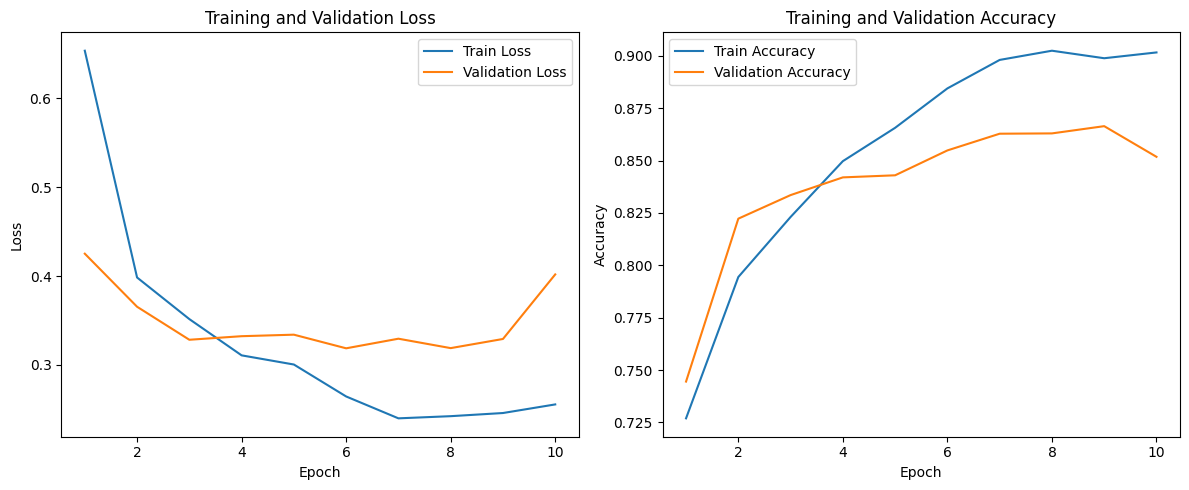

In [18]:
# Plot loss dan accuracy setelah training selesai
epochs = range(1, NUM_EPOCHS + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

*Interpretasi Setiap Bagian Output*

    Epoch:
    Setiap epoch merepresentasikan satu siklus penuh seluruh data latih yang diproses oleh model. Di sini, ada n epoch yang berarti model dilatih sebanyak n kali dengan seluruh dataset latih.

    Total Time:
    Menunjukkan total waktu yang diperlukan untuk menyelesaikan satu epoch. Misalnya, epoch 1 memakan waktu 1 menit.

    Train Loss dan Validation Loss:
    Train Loss: Merupakan nilai loss atau kerugian yang dihasilkan model pada data latih di setiap epoch. Nilai ini dihitung berdasarkan perbedaan antara prediksi model dengan label sebenarnya.
    Validation Loss: Merupakan nilai loss atau kerugian yang dihasilkan model pada data validasi. Ini dihitung dengan cara yang sama seperti train loss, tetapi pada data yang tidak digunakan untuk melatih model.
    Interpretasi:
    Penurunan Train Loss:
    Jika train loss menurun seiring epoch bertambah, model berhasil mempelajari pola-pola pada data latih.
    Penurunan Validation Loss:
    Penurunan pada validation loss menunjukkan bahwa model mempelajari pola yang juga berlaku pada data yang belum dilihat sebelumnya. Namun, jika validation loss justru meningkat setelah beberapa epoch, hal ini bisa menjadi indikasi bahwa model mulai overfitting, yaitu terlalu berfokus pada data latih dan kehilangan kemampuan untuk generalisasi pada data baru.

    Train Accuracy dan Validation Accuracy:
    Train Accuracy:
    Akurasi model pada data latih, menunjukkan persentase prediksi model yang benar pada data latih.
    Validation Accuracy:
    Akurasi model pada data validasi, menunjukkan persentase prediksi model yang benar pada data validasi.
    Interpretasi:
    Akurasi pada Data Latih:
    Akurasi yang meningkat menunjukkan bahwa model semakin baik dalam memprediksi data latih.
    Akurasi pada Data Validasi:
    Akurasi ini lebih penting karena menunjukkan seberapa baik model memprediksi data yang belum dilihat sebelumnya. Jika akurasi validasi menurun setelah beberapa epoch meskipun akurasi latih meningkat, ini mengindikasikan overfitting.

<a id='section8'></a>
# **8. Klasifikasi Sentimen**
Pada tahap klasifikasi sentimen, model BiLSTM yang telah dilatih sebelumnya kemudian akan diuji pada data uji. Data ini tidak terlibat sama sekali dalam proses pelatihan, jadi data ini baru bagi model dan berfungsi menguji performa penerapan model pada data ulasan. Model dengan validation loss terbaik pada tahap pelatihan yang akan digunakan, karena model ini dianggap memiliki kemampuan generalisasi yang paling baik.

In [24]:
# Memanggil model dengan validation loss terbaik
model.load_state_dict(torch.load('model-small.pt'))

# Evaluasi loss dan accuracy uji/test (apakah perlu?)
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print("Test Loss: {} | Test Acc: {}%".format(round(test_loss, 2), round(test_acc*100, 2)))

Test Loss: 0.31 | Test Acc: 85.97%


In [25]:
def predict(model, text, tokenized=True):
    """
    Memprediksi sentimen dari sebuah ulasan.

    text - string atau daftar token kata
    tokenized - True jika text adalah daftar token, False jika memasukkan string
    """
    
    # Menentukan perangkat yang akan digunakan, apakah GPU atau CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Mengatur model ke mode evaluasi (tanpa menghitung gradien)
    model.eval()

    if tokenized == False:
        # Jika input berupa string, lakukan tokenisasi menggunakan spacy
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text  # Jika input sudah berupa token, gunakan langsung

    # Mengonversi token ke indeks numerik dari kosakata model
    indexed_tokens = [TEXT.vocab.stoi[t] for t in tokens]
    # Mendapatkan panjang teks yang telah di-tokenisasi
    length = [len(indexed_tokens)]
    # Mengonversi indeks token menjadi tensor
    tensor = torch.LongTensor(indexed_tokens).to(device)
    # Menambah dimensi batch dengan unsqueeze
    tensor = tensor.unsqueeze(1)
    # Mengonversi panjang teks menjadi tensor
    length_tensor = torch.LongTensor(length)
    # Menghitung prediksi sentimen dengan mengonversi hasil model ke rentang antara 0 dan 1 menggunakan fungsi sigmoid
    prediction = torch.sigmoid(model(tensor, length_tensor))

    # Mengembalikan hasil prediksi sebagai nilai
    return 1 - prediction.item()

In [26]:
# Contoh prediksi sentimen dari satu ulasan dalam test set
# Ubah "processed_text" dan "vader_sentiment" sesuai dengan nama field yang Anda gunakan
print("Ulasan: {}".format(TreebankWordDetokenizer().detokenize(test_data[0].processed_text)))

print("Prediksi Sentimen: {}".format(round(predict(model, test_data[0].processed_text), 0)))

print("Label Asli: {}".format(test_data[0].vader_sentiment))

Ulasan: draiver prio maxim pusat ama untum order fiktif blokir nomor merekanagar order maxim sering nyantol dpt rating ngatif bodoh
Prediksi Sentimen: 1.0
Label Asli: 0.0


In [27]:
# Contoh prediksi sentimen dari seluruh ulasan dalam test set
# List untuk menyimpan data prediksi
d = []

# Loop melalui seluruh ulasan dalam test set
for idx in range(len(test_data)):

    # Detokenisasi ulasan dari test set
    ulasan = TreebankWordDetokenizer().detokenize(test_data[idx].processed_text)
    
    # Prediksi sentimen dari ulasan
    prediksi = predict(model, test_data[idx].processed_text)
    
    # Membulatkan nilai prediksi menjadi label (0 atau 1)
    label_prediksi = round(prediksi, 0)
    
    # Menyimpan hasil ulasan, prediksi, label prediksi, dan label asli ke dalam list
    d.append({
        'Ulasan': ulasan, 
        'Prediksi Sentimen': prediksi, 
        'Label Prediksi': label_prediksi,
        'Label Asli': test_data[idx].vader_sentiment
    })

# Konversi list ke dataframe untuk tampilan yang lebih baik
df_prediksi = pd.DataFrame(d)

# Simpan hasil prediksi ke file CSV
df_prediksi.to_csv('hasil_prediksi.csv', index=False)

print("Prediksi sentimen telah disimpan ke 'hasil_prediksi.csv'")

# Tampilkan beberapa hasil sebagai contoh
print(df_prediksi.head())

Prediksi sentimen telah disimpan ke 'hasil_prediksi.csv'
                                              Ulasan  Prediksi Sentimen  \
0  draiver prio maxim pusat ama untum order fikti...           0.504958   
1                              cepat layan nya bagus           0.999999   
2                                             mantap           0.999963   
3     apk aneh udh dicancel ttp aja gabisa maksa bgt           0.143965   
4                                   lokasi ga update           0.123562   

   Label Prediksi  Label Asli  
0             1.0         0.0  
1             1.0         1.0  
2             1.0         1.0  
3             0.0         0.0  
4             0.0         0.0  


<a id='section9'></a>
# **9. Evaluasi Model**
Pada tahap evaluasi model, performa model BiLSTM pada data uji akan dievaluasi berdasarkan beberapa metrik, yaitu accuracy, precision, dan recall. Hasil prediksi juga akan disajikan dalam bentuk confusion matrix, dimana bisa dilihat secara jelas jumlah klasifikasi yang sesuai atau tidak sesuai label aslinya.

In [52]:
# Fungsi evaluasi model untuk klasifikasi dua kelas (positif dan negatif)
def evaluate_model(model, iterator, criterion):
                          
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            # Ambil teks dan panjang teks dari batch
            text, text_lengths = batch.processed_text

            # Dapatkan prediksi model
            predictions = model(text, text_lengths).squeeze(1)
            
            # Konversi prediksi menjadi label (0 atau 1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            # Tambahkan prediksi dan label asli ke list
            all_predictions.extend(rounded_preds.cpu().numpy())
            all_labels.extend(batch.vader_sentiment.cpu().numpy())

    # Hitung metrik evaluasi untuk binary classification
    report = classification_report(all_labels, all_predictions, target_names=['Positif', 'Negatif'], output_dict=True)
    
    # Ambil metrik untuk sentimen positif
    accuracy = report['accuracy']
    positive_precision = report['Positif']['precision']
    positive_recall = report['Positif']['recall']
    positive_f1 = report['Positif']['f1-score']
    
    # Tampilkan classification report lengkap
    print(classification_report(all_labels, all_predictions, target_names=['Positif', 'Negatif']))

    # Buat confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positif', 'Negatif'], yticklabels=['Positif', 'Negatif'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, positive_precision, positive_recall, positive_f1, all_labels, all_predictions

              precision    recall  f1-score   support

     Positif       0.95      0.85      0.89      1074
     Negatif       0.73      0.90      0.80       495

    accuracy                           0.86      1569
   macro avg       0.84      0.87      0.85      1569
weighted avg       0.88      0.86      0.87      1569



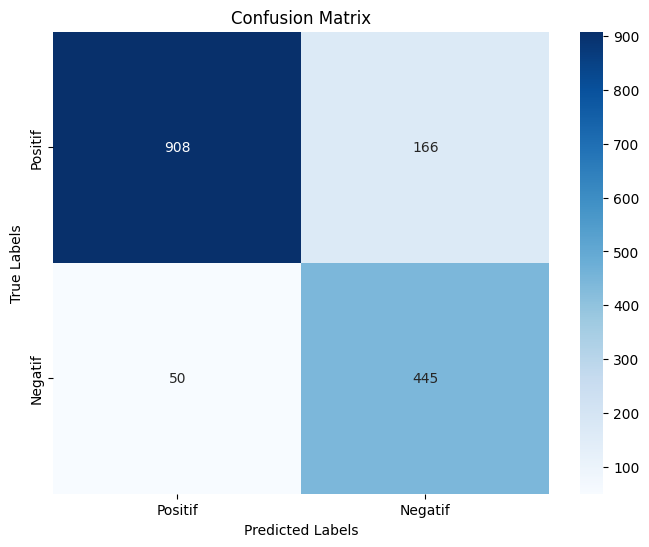

Accuracy: 0.86
Precision: 0.95
Recall: 0.85
F1 Score: 0.89


In [54]:
# Hitung metrik evaluasi pada data test
accuracy, precision, recall, f1, all_labels, all_predictions = evaluate_model(model, test_iterator, criterion)

# Tampilkan hasil metrik untuk sentimen positif
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

<a id='Miscellania'></a>
# **Miscellania**
Semua konten setelah ini tidak termasuk bagian dari pembuatan model analisis sentimen. Sel-sel di bawah hanya berisi kode tidak terpakai, kode untuk mengecek atau menguji berbagai hal terkait kode utama, dan berbagai catatan pribadi.

Beberapa metode untuk memperkecil ukuran dari word vector fastText.

In [ ]:
# fastText (quantize)
# Step 1: Load model fastText bahasa Indonesia yang telah diunduh (.bin)
ft = fasttext.load_model("cc.id.300.bin")  # Sesuaikan dengan path lokasi file

# Step 2: Kuantisasi model untuk mengurangi ukuran tanpa mengubah dimensi embedding
ft.quantize(input="cc.id.300.bin", qnorm=True, retrain=True, cutoff=100000)

# Step 3: Simpan model yang telah dikompresi
ft.save_model("cc.id.300.quantized.bin")

print("Model fastText telah dikompresi dan disimpan sebagai 'cc.id.300.quantized.bin'")

In [ ]:
# fastText (reduce_model versi pendek)
ft = fasttext.load_model("cc.id.300.bin")

# Kurangi dimensi dari 300 menjadi 100
fasttext.util.reduce_model(ft, 100)

# Simpan model yang lebih kecil
ft.save_model("cc.id.100.bin")

print("Model fastText telah dikompresi ke dimensi 100 dan disimpan sebagai 'cc.id.100.bin'")

In [ ]:
# fastText (reduce_model)
# Step 1: Load model fastText yang telah diunduh (gunakan file .bin)
ft = fasttext.load_model("cc.id.300.bin")  # Sesuaikan path lokasi file

# Step 2: Kurangi dimensi dari 300 ke 100
fasttext.util.reduce_model(ft, 100)

# Step 3: Tentukan ukuran maksimal kosakata
MAX_VOCAB_SIZE = 25000

# Step 4: Bangun kosakata dari data training
word_freqs = Counter(word for example in train_data.examples for word in example.processed_text)
vocab = Vocab(word_freqs, max_size=MAX_VOCAB_SIZE)

# Step 5: Buat tensor untuk menyimpan embedding yang telah diperkecil
embedding_matrix = torch.zeros(len(vocab), 100)  # 100 dimensi setelah reduksi

# Step 6: Masukkan vektor fastText ke dalam tensor embedding_matrix
for idx, word in enumerate(vocab.itos):
    embedding_matrix[idx] = torch.tensor(ft.get_word_vector(word))

# Step 7: Set embedding ke dalam `TEXT.vocab.vectors`
TEXT.vocab = vocab
TEXT.vocab.vectors = embedding_matrix

# Step 8: Bangun kosakata untuk label (LABEL) dari data training
LABEL.build_vocab(train_data)

# Step 9: Tampilkan token yang paling sering muncul di data training
print("Token yang paling sering muncul:")
print(vocab.freqs.most_common(10))

# Step 10: Pastikan ukuran embedding sudah berubah
print("Dimensi vektor setelah reduksi:", TEXT.vocab.vectors.shape)  # Harus [num_vocab, 100]

Kode untuk membangun kosakata fastText dari data latih menggunakan model asli dari website resminya.

In [ ]:
# Membangun kosakata fastText
# Step 1: Tentukan ukuran maksimal kosakata
MAX_VOCAB_SIZE = 25000

# Step 2: Muat embedding fastText bahasa Indonesia dari file yang sudah diunduh
fasttext_vectors = Vectors(name='cc.id.300.vec', cache='.')  # Sesuaikan path lokasi penyimpanan file

# Step 3: Membangun kosakata untuk teks (TEXT) dari data training
TEXT.build_vocab(train_data, 
                 max_size=MAX_VOCAB_SIZE,
                 vectors=fasttext_vectors,
                 unk_init=torch.Tensor.normal_)  # Inisialisasi kata yang tidak ditemukan di embedding

# Step 4: Membangun kosakata untuk label (LABEL) dari data training
LABEL.build_vocab(train_data)

# Step 5: Tampilkan token yang paling sering muncul di data training
print("Token yang paling sering muncul:")
print(TEXT.vocab.freqs.most_common(10))

Kode untuk mengambil satu sampel dari data latih

In [ ]:
# Sampel dari dataset training
print(vars(train_iterator.dataset[0]))

Kode untuk mengecek token dalam matriks embedding

In [ ]:
# Cek token dalam model fastText
test_token = "maxim"  # Ganti dengan token lain yang sering muncul
if test_token in ft_compressed.key_to_index:
    print(f"Token '{test_token}' ditemukan di fastText!")
    print(f"Vektor embedding: {ft_compressed[test_token]}")
else:
    print(f"Token '{test_token}' TIDAK ditemukan di fastText!")

Kode scraping data versi lama.

In [3]:
# Kode untuk data skripsi (data_scraping.csv)
# Membaca file .csv hasil scraping ulasan
df = pd.read_csv("data_scraping.csv", engine="python", header=None)

# Hapus kolom yang tidak diperlukan, yang diambil hanya "content"
columns_to_drop = [0,1,2,4,5,6,7,8,9,10]
df = df.drop(columns=columns_to_drop)

# Hapus baris pertama
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

# Simpan dataframe yang telah diubah ke dalam file .csv
df.to_csv('review_content.csv', index=False)

# Memanggil data
df.head(5)

,content
1,manteps driver nya
2,baik cepat murah
3,"Maps nya susah ga sesuai lokasi kita,, beda sa..."
4,sangat puas
5,ok


In [ ]:
for batch in test_iterator:
    text, text_lengths = batch.processed_text
    predictions = model(text, text_lengths).squeeze(1)  # Hasil sebelum thresholding
    print(predictions[:20])  # Lihat 20 nilai pertama
    break

In [ ]:
# Buat DataFrame dari hasil prediksi pada data uji
df_results = pd.DataFrame({
    'True_Label': all_labels,
    'Predicted_Label': all_predictions
})

# Simpan ke file CSV
df_results.to_csv('model_predictions.csv', index=False)

print("Hasil prediksi telah disimpan dalam 'model_predictions.csv'")

              precision    recall  f1-score   support

     Negatif       0.86      0.95      0.90       502
     Positif       0.82      0.61      0.70       205

    accuracy                           0.85       707
   macro avg       0.84      0.78      0.80       707
weighted avg       0.85      0.85      0.84       707



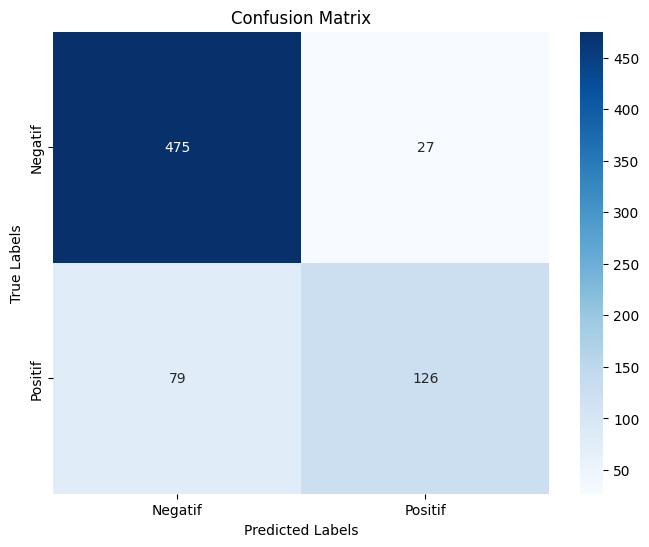

Akurasi: 0.85
Presisi: 0.82
Recall: 0.61
F1 Score: 0.70


In [26]:
# Konversi all_labels ke NumPy array sebelum operasi
all_labels = np.array(all_labels)

# Tukar label dalam confusion matrix
cm = confusion_matrix(1 - all_labels, all_predictions)

# Hitung metrik evaluasi pada data test
accuracy, precision, recall, f1, all_labels, all_predictions = evaluate_model(model, test_iterator, criterion)

# Tampilkan hasil
print(f"Akurasi: {accuracy:.2f}")
print(f"Presisi: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [28]:
# Konversi list ke NumPy array jika belum
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Cek distribusi label sebelum evaluasi
print(f"Jumlah label positif: {np.sum(all_labels == 1)}")
print(f"Jumlah label negatif: {np.sum(all_labels == 0)}")

# Cek distribusi prediksi model
print(f"Jumlah prediksi positif: {np.sum(all_predictions == 1)}")
print(f"Jumlah prediksi negatif: {np.sum(all_predictions == 0)}")

Jumlah label positif: 205
Jumlah label negatif: 502
Jumlah prediksi positif: 153
Jumlah prediksi negatif: 554


In [29]:
print(df['vader_sentiment'].value_counts())  # Untuk dataset awal
print(pd.Series(all_labels).value_counts())  # Untuk dataset evaluasi

vader_sentiment
positif    2495
negatif    1041
Name: count, dtype: int64
0.0    502
1.0    205
Name: count, dtype: int64


In [ ]:
# Dapatkan vektor embedding dari sebuah kata setelah reduksi model
vector = ft.get_word_vector("transportasi")
print(vector)

In [ ]:
# Kode uji cutoff yang optimal menggunakan quantize
for cutoff in [100000, 50000, 25000, 10000, 5000]:
    ft = fasttext.load_model("cc.id.300.bin")
    ft.quantize(qnorm=True, retrain=True, cutoff=cutoff)
    ft.save_model(f"cc.id.300.quantized_{cutoff}.bin")
    print(f"Model fastText dengan cutoff {cutoff} disimpan!")

In [ ]:
# Evaluasi model setelah reduksi model degan quantize
from sklearn.metrics import accuracy_score

# Load model yang sudah dikurangi dimensinya atau dikompresi
ft = fasttext.load_model("cc.id.100.quantized_50000.bin")

# Cek akurasi pada dataset validasi
predictions = [ft.predict(text)[0][0] for text in valid_texts]  # Ubah sesuai dataset validasi Anda
accuracy = accuracy_score(valid_labels, predictions)

print(f"Akurasinya: {accuracy:.4f}")

In [ ]:
# MENGGUNAKAN DATA VALIDASI
# Jumlah epoch untuk melatih model
NUM_EPOCHS = 10

# Inisialisasi nilai terendah untuk validasi loss
best_valid_loss = float('inf')

# List untuk menyimpan nilai loss dan accuracy pada setiap epoch
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Loop untuk setiap epoch
for epoch in range(NUM_EPOCHS):

    start_time = time.time()  # Catat waktu mulai epoch
    
    # Menghitung loss dan akurasi pada data latihan
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # Menghitung loss dan akurasi pada data validasi
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()  # Catat waktu akhir epoch

    # Simpan nilai loss dan accuracy dari setiap epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    # Menghitung waktu total yang dihabiskan untuk setiap epoch
    mins, secs = timer(start_time, end_time)
    
    # Mengecek apakah validasi loss saat ini lebih baik dari sebelumnya
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss  # Perbarui nilai validasi loss terbaik
        torch.save(model.state_dict(), 'model-small.pt')  # Simpan parameter model jika validasi loss terbaik diperoleh

    # Menampilkan hasil dari setiap epoch
    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Precision, Recall, F1-score, dan Support untuk Setiap Kelas

    Kelas 0.0 (Negatif, misalnya):
        Precision: 0.87 — 87% dari prediksi kelas 0.0 adalah benar.
        Recall: 0.76 — 76% dari contoh data sebenarnya yang berlabel 0.0 berhasil diprediksi dengan benar.
        F1-score: 0.81 — Ini adalah rata-rata harmonis dari precision dan recall untuk kelas 0.0.
        Support: 17 — Ada 17 contoh data yang memiliki label 0.0 dalam dataset ini.
    Kelas 1.0 (Positif, misalnya):
        Precision: 0.20 — Hanya 20% dari prediksi kelas 1.0 yang benar-benar positif.
        Recall: 0.33 — Model hanya mampu mendeteksi 33% dari contoh data yang seharusnya berlabel 1.0.
        F1-score: 0.25 — Rata-rata harmonis dari precision dan recall untuk kelas 1.0.
        Support: 3 — Hanya ada 3 contoh data yang berlabel 1.0 di dalam dataset ini.

Interpretasi:

    Kelas 0.0 memiliki nilai precision, recall, dan F1-score yang jauh lebih tinggi dibandingkan kelas 1.0. Ini menunjukkan bahwa model Anda lebih baik dalam memprediksi kelas 0.0 dibandingkan kelas 1.0.
    Kelas 1.0 memiliki metrik yang rendah, yang mengindikasikan bahwa model kesulitan dalam mendeteksi contoh yang berlabel 1.0.

Akurasi (Accuracy)

    Akurasi: 0.70 — Model memiliki akurasi sebesar 70%, yang berarti 70% dari total prediksi model adalah benar.
    Akurasi menunjukkan keseluruhan prediksi yang benar, namun pada dataset yang tidak seimbang, akurasi bisa menyesatkan. Misalnya, jika sebagian besar data berlabel 0, model mungkin hanya fokus pada prediksi 0 untuk mendapatkan akurasi tinggi.

Macro Average (Rata-rata Makro)

    Macro avg untuk precision, recall, dan F1-score adalah rata-rata metrik dari masing-masing kelas, tanpa mempertimbangkan jumlah contoh (support) di setiap kelas.
    Pada hasil ini:
        Macro Precision: 0.53 — Rata-rata precision dari dua kelas (0.87 dan 0.20) adalah 0.53.
        Macro Recall: 0.55 — Rata-rata recall dari dua kelas (0.76 dan 0.33) adalah 0.55.
        Macro F1: 0.53 — Rata-rata F1-score dari dua kelas (0.81 dan 0.25) adalah 0.53.

Interpretasi:

    Macro avg menunjukkan kinerja rata-rata tanpa memperhatikan ketidakseimbangan kelas, sehingga ini berguna untuk memahami performa model di kedua kelas secara seimbang.

Weighted Average (Rata-rata Tertimbang)

    Weighted avg mempertimbangkan support (jumlah contoh) di setiap kelas. Metrik ini lebih relevan untuk dataset yang tidak seimbang.
    Pada hasil ini:
        Weighted Precision: 0.77 — Precision keseluruhan tertimbang berdasarkan jumlah contoh di tiap kelas.
        Weighted Recall: 0.70 — Recall keseluruhan tertimbang.
        Weighted F1: 0.73 — F1-score keseluruhan tertimbang.

Interpretasi:

    Weighted avg lebih mencerminkan performa aktual model pada dataset yang tidak seimbang. Nilai weighted F1-score sebesar 0.73 menunjukkan bahwa, meskipun model cukup baik untuk kelas mayoritas (0.0), performanya pada kelas minoritas (1.0) perlu ditingkatkan.

Kode ini berfungsi untuk evaluasi model, namun versi ini menunjukkan metrik untuk sentimen negatif. Kode ini juga versi asli dari evaluasi model.

In [ ]:
# Fungsi evaluasi model untuk klasifikasi dua kelas (positif dan negatif)
def evaluate_model(model, iterator, criterion):
                          
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            # Ambil teks dan panjang teks dari batchoss
            text, text_lengths = batch.processed_text

            # Dapatkan prediksi model
            predictions = model(text, text_lengths).squeeze(1)
            
            # Konversi prediksi menjadi label (0 atau 1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            # Tambahkan prediksi dan label asli ke list
            all_predictions.extend(rounded_preds.cpu().numpy())
            all_labels.extend(batch.vader_sentiment.cpu().numpy())

    # Hitung metrik evaluasi untuk binary classification
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    
    # Tampilkan laporan klasifikasi lengkap (opsional)
    print(classification_report(all_labels, all_predictions, target_names=['Positif', 'Negatif']))
    
    # Buat confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positif', 'Negatif'], yticklabels=['Positif', 'Negatif'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, precision, recall, f1, all_labels, all_predictions

In [ ]:
# Hitung metrik evaluasi pada data test
accuracy, precision, recall, f1, all_labels, all_predictions = evaluate_model(model, test_iterator, criterion)

# Tampilkan hasil
print(f"Akurasi: {accuracy:.2f}")
print(f"Presisi: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

### **Kode Bersih**
Kode yang lebih bersih dan padat guna mengefisienkan ruang. Digunakan untuk kebutuhan skripsi.

Text Preprocessing

In [ ]:
# Kode per langkah preprocessing
# Step 1: Cleansing text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Case folding
def case_folding(text):
    return text.lower()

# Step 3: Tokenisasi
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc] 

# Step 4: Menghapus stopword menggunakan daftar dari Sastrawi
stopword_factory = StopWordRemoverFactory()
stopword_list = set(stopword_factory.get_stop_words()) 

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopword_list]

# Step 5: Stemming menggunakan Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

In [ ]:
# Fungsi untuk menyimpan hasil setiap langkah ke CSV
def save_to_csv(df, step_name):
    filename = f'processed_data_{step_name}.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {step_name} result to {filename}")

# Fungsi utama untuk memproses dan menyimpan setiap langkah
def process_and_save_steps(df):
    # Step 1: Cleansing text
    df['cleaned_text'] = df['content'].apply(clean_text)
    save_to_csv(df[['content', 'cleaned_text']], 'cleansing')

    # Step 2: Case folding
    df['case_folding'] = df['cleaned_text'].apply(case_folding)
    save_to_csv(df[['cleaned_text', 'case_folding']], 'case_folding')

    # Step 3: Tokenisasi
    df['tokenized_text'] = df['case_folding'].apply(tokenize)
    save_to_csv(df[['case_folding', 'tokenized_text']], 'tokenization')

    # Step 4: Penghapusan stopword
    df['no_stopwords'] = df['tokenized_text'].apply(remove_stopwords)
    save_to_csv(df[['tokenized_text', 'no_stopwords']], 'stopword_removal')

    # Step 5: Stemming
    df['stemmed_text'] = df['no_stopwords'].apply(stemming)
    save_to_csv(df[['no_stopwords', 'stemmed_text']], 'stemming')

# Membaca file CSV sebagai DataFrame
df = pd.read_csv('review_content.csv')

# Menjalankan proses preprocessing
process_and_save_steps(df)